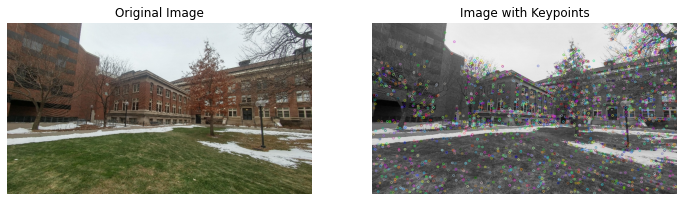

In [8]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
 
img_1 = cv.imread('/Users/chehakmalhotra/Desktop/cva3/panaroma_generation/1.jpg')
gray= cv.cvtColor(img_1,cv.COLOR_BGR2GRAY)
 
sift = cv.SIFT_create()
#kp = sift.detect(gray,None)



kp1, des1 = sift.detectAndCompute(gray, None)

img_1_with_keypoints = cv.drawKeypoints(gray, kp1, img_1.copy())


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(img_1, cv.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(img_1_with_keypoints, cv.COLOR_BGR2RGB))
plt.title('Image with Keypoints')
plt.axis('off')

plt.show()
 

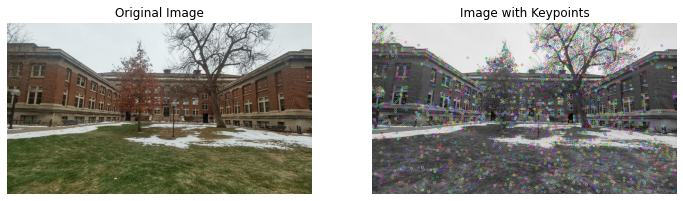

In [9]:
img_2 = cv.imread('/Users/chehakmalhotra/Desktop/cva3/panaroma_generation/2.jpg')
gray= cv.cvtColor(img_2,cv.COLOR_BGR2GRAY)
 
sift = cv.SIFT_create()
#kp = sift.detect(gray,None)

kp2, des2 = sift.detectAndCompute(gray, None)
 


img_2_with_keypoints = cv.drawKeypoints(gray, kp2, img_2.copy())


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(img_2, cv.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(img_2_with_keypoints, cv.COLOR_BGR2RGB))
plt.title('Image with Keypoints')
plt.axis('off')

plt.show()

In [10]:

bf = cv.BFMatcher(cv.NORM_L2, crossCheck=True)


matches_bf = bf.match(des1, des2)


index_params = dict(algorithm=1, trees=5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params, search_params)


matches_flann = flann.match(des1, des2)



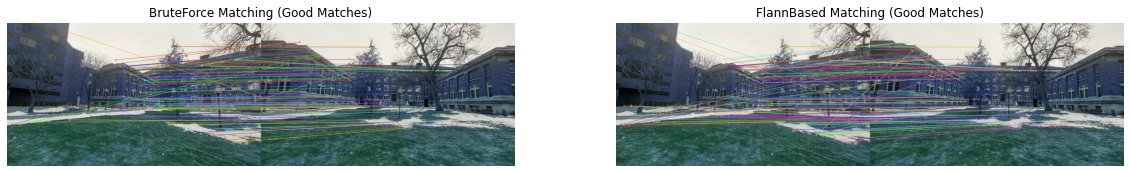

In [11]:
good_matches_bf = []
good_matches_flann = []

for match in matches_bf:
    if match.distance < 0.75 * matches_bf[1].distance:
        good_matches_bf.append(match)

for match in matches_flann:
    if match.distance < 0.4 * matches_flann[1].distance:
        good_matches_flann.append(match)

# Draw only good matches
img_matches_bf = cv.drawMatches(img_1, kp1, img_2, kp2, good_matches_bf, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
img_matches_flann = cv.drawMatches(img_1, kp1, img_2, kp2, good_matches_flann, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display images with only good matches
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(img_matches_bf)
plt.title('BruteForce Matching (Good Matches)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_matches_flann)
plt.title('FlannBased Matching (Good Matches)')
plt.axis('off')

plt.show()

In [12]:
print('Number of matches using BruteForce: ', len(good_matches_bf))

Number of matches using BruteForce:  117


In [13]:
print('Number of matches using flann: ', len(good_matches_flann))

Number of matches using flann:  147


In [14]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1,des2,k=2)
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
 if m.distance < 0.7*n.distance:
    good.append(m)

In [15]:
src_pts = np.float32([ kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)

In [16]:
M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,0.1)

In [17]:
print(M)

[[-4.41834556e+01  2.63158299e-01  1.61225682e+04]
 [-1.33679586e+01 -2.77025160e+01  8.39994722e+03]
 [-4.57888614e-02 -2.43744309e-03  1.00000000e+00]]


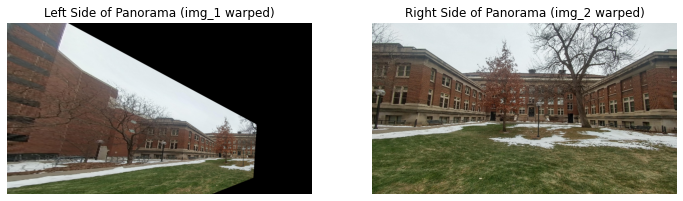

In [18]:
translation = np.array([[1, 0, img_1.shape[1]], [0, 1, img_1.shape[0]], [0, 0, 1]]) 
left_side = cv.warpPerspective(img_1, np.dot(translation,M), (img_1.shape[1]+img_2.shape[1], img_1.shape[0]+img_2.shape[0]))


right_side = img_2

# Display the left and right sides of the panorama using Matplotlib
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(left_side, cv.COLOR_BGR2RGB))
plt.title('Left Side of Panorama (img_1 warped)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(right_side, cv.COLOR_BGR2RGB))
plt.title('Right Side of Panorama (img_2 warped)')
plt.axis('off')

plt.show()

Text(0.5, 1.0, 'Stitched Image (without cropping)')

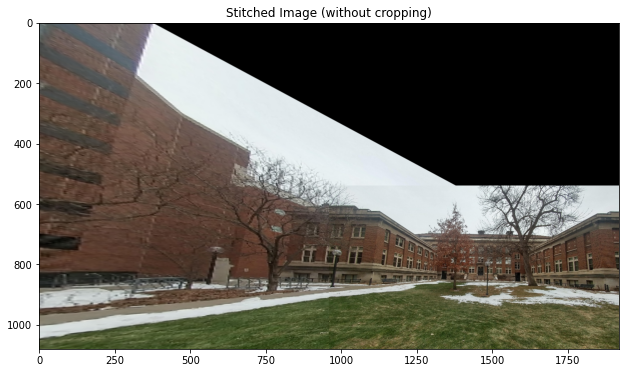

In [20]:
stitched_image = left_side.copy()
stitched_image[img_1.shape[0]:, img_1.shape[1]:] = img_2

plt.figure(figsize=(12, 6))
plt.imshow(cv.cvtColor(stitched_image, cv.COLOR_BGR2RGB))
plt.title('Stitched Image (without cropping)')

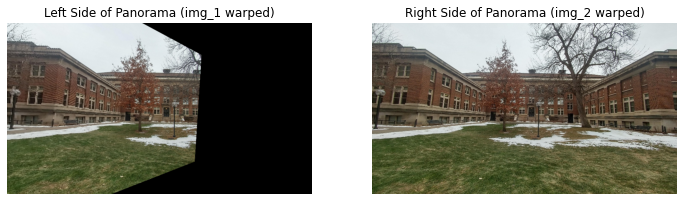

In [21]:
left_side = cv.warpPerspective(img_1,M, (img_1.shape[1], img_1.shape[0]))


right_side = img_2

# Display the left and right sides of the panorama using Matplotlib
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(left_side, cv.COLOR_BGR2RGB))
plt.title('Left Side of Panorama (img_1 warped)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(right_side, cv.COLOR_BGR2RGB))
plt.title('Right Side of Panorama (img_2 warped)')
plt.axis('off')

plt.show()

Text(0.5, 1.0, 'Blended Image')

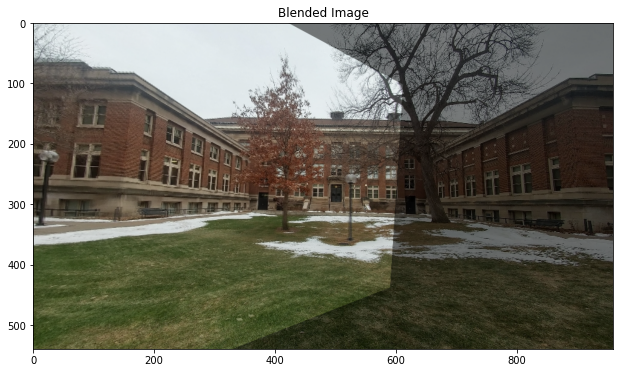

In [22]:
alpha = 0.5
beta = 1.0 - alpha  
gamma = 0  
blended_image = cv.addWeighted(left_side, alpha, right_side, beta, gamma)

plt.figure(figsize=(12, 6))
plt.imshow(cv.cvtColor(blended_image, cv.COLOR_BGR2RGB))
plt.title('Blended Image')

In [23]:
print('Left Side of Panorama (img_1 warped):', left_side.shape)
print('Right Side of Panorama (img_2 warped):', right_side.shape)

Left Side of Panorama (img_1 warped): (540, 960, 3)
Right Side of Panorama (img_2 warped): (540, 960, 3)


In [29]:
translation = np.array([[1, 0, img_1.shape[1]], [0, 1, img_1.shape[0]], [0, 0, 1]]) 
left_side = cv.warpPerspective(img_1, np.dot(translation,M), (img_1.shape[1]+img_2.shape[1], img_1.shape[0]+img_2.shape[0]))


right_side = img_2



stitched_image = left_side.copy()
stitched_image[img_1.shape[0]:, img_1.shape[1]:] = img_2


Text(0.5, 1.0, 'Stitched Image (with cropping)')

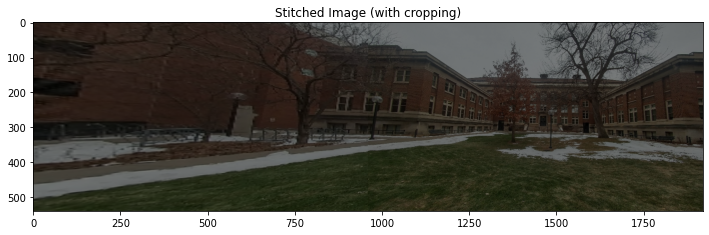

In [30]:
stitched_img_1 = np.zeros((max(img_1.shape[0], img_2.shape[0]), img_1.shape[1] + img_2.shape[1], 3), dtype=np.uint8)

stitched_img_2 = np.zeros((max(img_1.shape[0], img_2.shape[0]), img_1.shape[1] + img_2.shape[1], 3), dtype=np.uint8)

stitched_img_1[:img_1.shape[0], :img_1.shape[1]] = left_side[img_1.shape[0]:, :img_1.shape[1]]


stitched_img_2[:img_2.shape[0], img_1.shape[1]:] = img_2


alpha = 0.5 
beta = 1.0 - alpha  
gamma = 0  
blended_image = cv.addWeighted(stitched_img_1, alpha, stitched_img_2, beta, gamma)

plt.figure(figsize=(12, 6))
plt.imshow(cv.cvtColor(blended_image, cv.COLOR_BGR2RGB))
plt.title('Stitched Image (with cropping)')

In [31]:

images=[]
import os
for filename in os.listdir('panaroma_generation'):
        filepath = os.path.join('panaroma_generation', filename)
        if os.path.isfile(filepath):

            if filename.endswith(('.png', '.jpg', '.jpeg', '.gif')):
                image = cv.imread(filepath)
                if image is not None:
                    images.append(image)


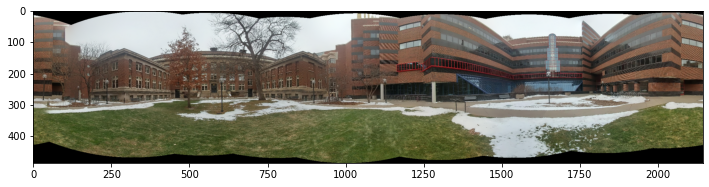

In [32]:
stitcher = cv.Stitcher_create()
status, stitched_img = stitcher.stitch(images)

plt.figure(figsize=(12, 6))

plt.imshow(cv.cvtColor(stitched_img, cv.COLOR_BGR2RGB))


